In [24]:
!pip install spikingjelly mne


In [25]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from spikingjelly.clock_driven import neuron, functional, monitor


In [26]:
# Load the dataset
df = pd.read_csv('/kaggle/input/eeg-brainwave-dataset-feeling-emotions/emotions.csv')

# Features and labels
X = df.iloc[:, 3:-1].values  # EEG features (32 channels)
y = df['label'].values       # Emotion labels (positive, negative, neutral)

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # 0,1,2


In [27]:
# Rate encoding: convert float input to spike trains
def rate_encode(signal, time_steps=50):
    return (np.random.rand(time_steps, signal.shape[0]) < signal).astype(np.float32)

# Encode each sample
X_spike = np.array([rate_encode(s, time_steps=50) for s in X_scaled])


In [28]:
X_tensor = torch.tensor(X_spike, dtype=torch.float32)  # shape: [samples, time, features]
y_tensor = torch.tensor(y_encoded, dtype=torch.long)

dataset = data.TensorDataset(X_tensor, y_tensor)
train_loader = data.DataLoader(dataset, batch_size=32, shuffle=True)


In [29]:
class EEGSNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=3):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.sn1 = neuron.LIFNode()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sn2 = neuron.LIFNode()

    def forward(self, x):  # x: [batch, time, features]
        out = None
        for t in range(x.shape[1]):
            xt = x[:, t]
            xt = self.fc1(xt)
            xt = self.sn1(xt)
            xt = self.fc2(xt)
            xt = self.sn2(xt)
            out = xt if out is None else out + xt
        return out / x.shape[1]  # average across time


In [30]:
input_size = X_tensor.shape[2]
model = EEGSNN(input_size=input_size)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        out = model(batch_x)
        loss = criterion(out, batch_y)
        loss.backward()
        optimizer.step()
        functional.reset_net(model)
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss:.4f}")


Epoch 1/50 - Loss: 48.5588
Epoch 2/50 - Loss: 41.5088
Epoch 3/50 - Loss: 40.7223
Epoch 4/50 - Loss: 40.1142
Epoch 5/50 - Loss: 39.4301
Epoch 6/50 - Loss: 38.8570
Epoch 7/50 - Loss: 38.3483
Epoch 8/50 - Loss: 37.6487
Epoch 9/50 - Loss: 37.2964
Epoch 10/50 - Loss: 37.2407
Epoch 11/50 - Loss: 37.1608
Epoch 12/50 - Loss: 37.0686
Epoch 13/50 - Loss: 37.0439
Epoch 14/50 - Loss: 37.0237
Epoch 15/50 - Loss: 37.0006
Epoch 16/50 - Loss: 36.9862
Epoch 17/50 - Loss: 36.9658
Epoch 18/50 - Loss: 36.9592
Epoch 19/50 - Loss: 36.9526
Epoch 20/50 - Loss: 36.9531
Epoch 21/50 - Loss: 36.9501
Epoch 22/50 - Loss: 36.9499
Epoch 23/50 - Loss: 36.9487
Epoch 24/50 - Loss: 36.9491
Epoch 25/50 - Loss: 36.9483
Epoch 26/50 - Loss: 36.9473
Epoch 27/50 - Loss: 36.9475
Epoch 28/50 - Loss: 36.9468
Epoch 29/50 - Loss: 36.9469
Epoch 30/50 - Loss: 36.9468
Epoch 31/50 - Loss: 36.9468
Epoch 32/50 - Loss: 36.9468
Epoch 33/50 - Loss: 36.9468
Epoch 34/50 - Loss: 36.9468
Epoch 35/50 - Loss: 36.9468
Epoch 36/50 - Loss: 36.9469
E

In [31]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in train_loader:
        out = model(batch_x)
        preds = torch.argmax(out, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())
        functional.reset_net(model)

acc = accuracy_score(all_labels, all_preds)
print(f"\n Final Accuracy: {acc * 100:.2f}%")



 Final Accuracy: 100.00%


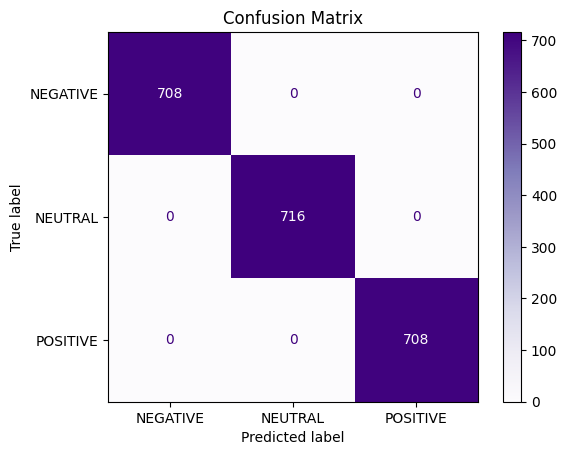

In [32]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Purples")
plt.title("Confusion Matrix")
plt.show()
